# Sampling Is Not Solved: Silent Failures in Modern MCMC


In [1]:
# Install only if needed
# Uncomment and run if libraries are missing
#!pip install torch matplotlib scikit-learn tqdm
!pip install arviz scipy pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 183.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Configuration-driven universal setup cell
import os
import sys
from pathlib import Path

# Fix OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Centralized configuration
IMPORT_CONFIG = {
    'utils': ['get_data', 'plot_real_data'],
    'mcmc': ['two_moons_logp_circular', 'grad_logp_circular', 'two_moons_model', 'banana_logp', 'banana_grad_logp', 'banana_model', 'generate_true_banana_samples', 'run_smc', 'run_mala', 'run_hmc_adaptive', 'run_nuts', 'compute_validation_metrics', 'run_experiment'],
    'visualization': ['plot_true_contour_and_samples'],
    'diagnostics': ['plot_diagnostics_grid_az']
}

def setup_imports():
    """Setup imports using configuration."""
    
    # Try package imports first
    try:
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(f'src.{module}', fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Package imports successful")
        return imported_functions
    except ImportError:
        pass
    
    # Try direct path imports
    try:
        src_path = Path("src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(module, fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Direct imports successful")
        return imported_functions
    except ImportError:
        pass
    
    # Try parent directory
    try:
        src_path = Path("../src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(module, fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Parent directory imports successful")
        return imported_functions
    except ImportError:
        pass
    
    raise ImportError("Could not import required modules from src/")

# Setup imports
try:
    imports = setup_imports()
    globals().update(imports)  # Add all to global namespace
    print("All imports ready")
except Exception as e:
    print(f"Import setup failed: {e}")
    raise

# Test
try:
    x_real = get_data(100, normalize=False)  # Uses the imported function
    print(f"Test successful: {x_real.shape}")
except Exception as e:
    print(f"Test failed: {e}")

/root/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Parent directory imports successful
All imports ready
Test successful: torch.Size([100, 2])


In [3]:
# IMPORTS
import numpy as np
import torch
#import arviz as az
import matplotlib.pyplot as plt

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# CONFIG
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seeds
torch.manual_seed(42)
np.random.seed(42)

## Introduction: The Myth of the Perfect Sampler

In theory, MCMC methods like HMC and NUTS are powerful tools for sampling complex distributions. In practice, they often fail — not with error messages, but with silence.

This notebook explores what happens when we apply several MCMC algorithms to two classic testbeds: the banana distribution (curved, singly connected) and the two-moons distribution (bimodal, disconnected).

We find:
- Vanilla HMC fails completely without tuning
- NUTS generates beautiful samples — but only from one mode
- SMC finds both modes, but at higher cost

The lesson: **A sampler that looks perfect may still be wrong.**

This has profound implications for Energy-Based Models and other generative approaches that rely on Langevin dynamics.

## Distributions: Banana and Two Moons

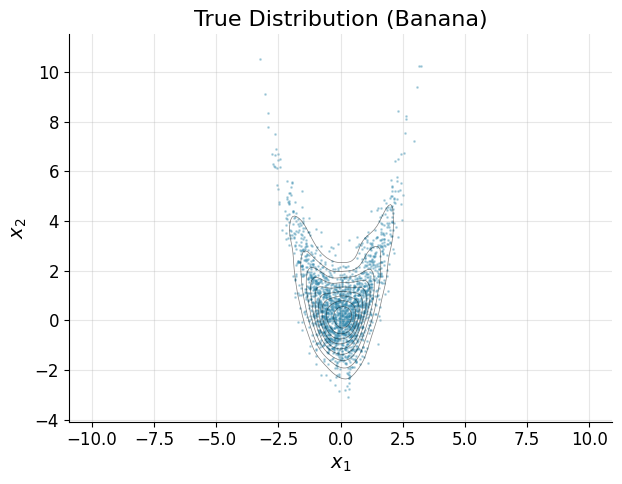

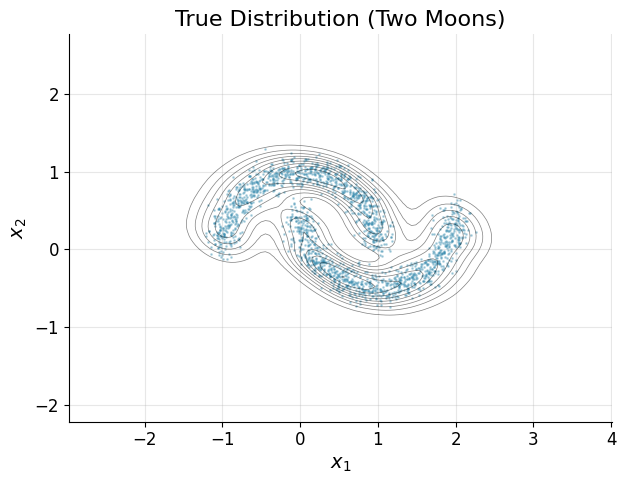

In [4]:
# Generate true samples
true_banana = generate_true_banana_samples(n=2000)
true_moons = get_data(2000, normalize=False)

# Plot banana
plot_true_contour_and_samples(true_banana, {}, name='Banana')

# Plot moons  
plot_true_contour_and_samples(true_moons, {}, name='Two Moons')

## Samplers: From HMC to NUTS

We compare four samplers:
- **MALA**: Uses gradient information, but local moves only
- **HMC (adaptive)**: Implements dual averaging for step size adaptation
- **SMC / Particle Filter**: Global exploration via resampling
- **NUTS (Pyro)**: State-of-the-art adaptive sampler

All are implemented in `src/mcmc.py`. We use default hyperparameters unless noted.

## Results: What Went Wrong?

=== BANANA DISTRIBUTION ===

Running MALA...
MALA: 100%|██████████| 1000/1000 [00:00<00:00, 1379.75it/s]
MALA ESS: 1.5

Running Adaptive HMC...
HMC Adaptive: 100%|██████████| 1200/1200 [00:03<00:00, 310.26it/s]
Final step size: 0.0968, Accept rate: 0.077
Adaptive HMC ESS: 2.0

Running SMC...
SMC ESS: 1055.0

Running NUTS...
Sample: 100%|██████████| 1200/1200 [00:09, 127.06it/s, step size=4.83e-01, acc. prob=0.895]
Chain 1 mean: [-0.01322489  0.5639395 ]
Combined mean: [-0.01322489  0.5639395 ]
Chain means spread: [0. 0.]
NUTS ESS: 453.8

                      ESS
MALA             1.518757
Adaptive HMC     1.953619
SMC           1054.966568
NUTS           453.765086


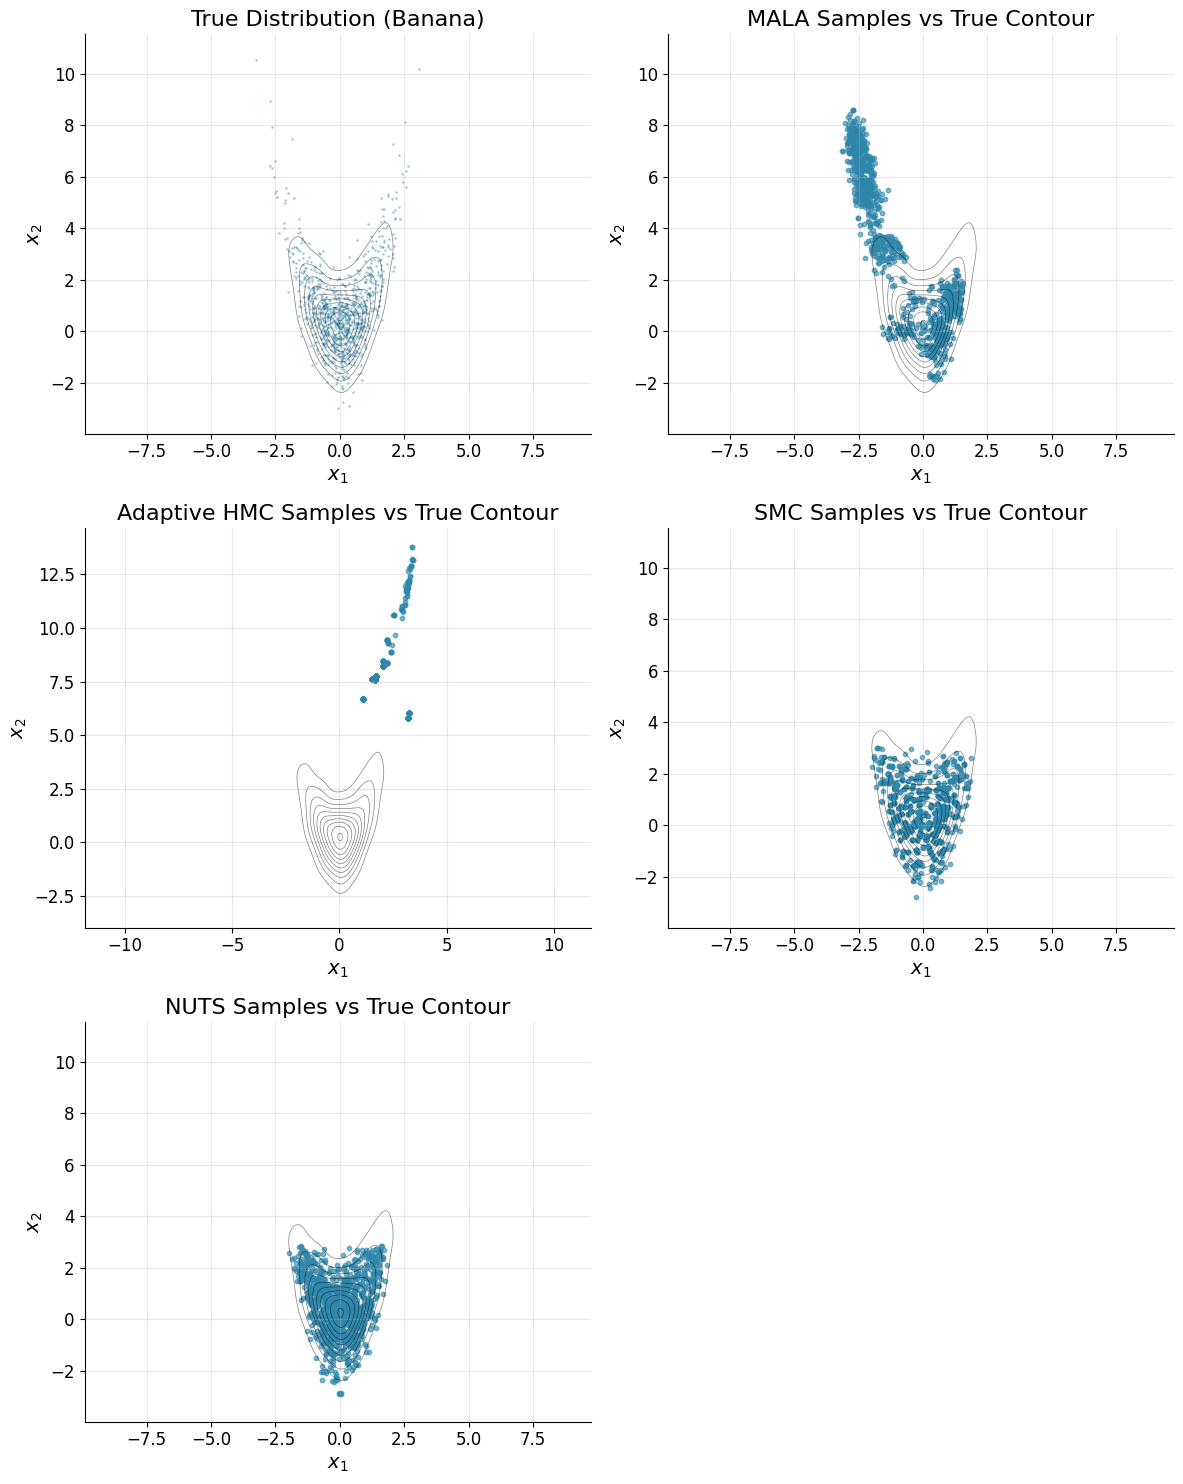

=== TWO MOONS DISTRIBUTION ===

Running MALA...
MALA: 100%|██████████| 1000/1000 [00:01<00:00, 673.14it/s]
MALA ESS: 4.1

Running Adaptive HMC...
HMC Adaptive: 100%|██████████| 1200/1200 [00:08<00:00, 143.23it/s]
Final step size: 0.1074, Accept rate: 0.004
Adaptive HMC ESS: 1000.0

Running SMC...
SMC ESS: 951.7

Running NUTS...
Sample: 100%|██████████| 1200/1200 [01:23, 14.37it/s, step size=5.61e-02, acc. prob=0.910]
Chain 1 mean: [0.02998984 0.5959706 ]
Combined mean: [0.02998984 0.5959706 ]
Chain means spread: [0. 0.]
NUTS ESS: 134.4

                      ESS
MALA             4.134651
Adaptive HMC  1000.000000
SMC            951.693007
NUTS           134.430128


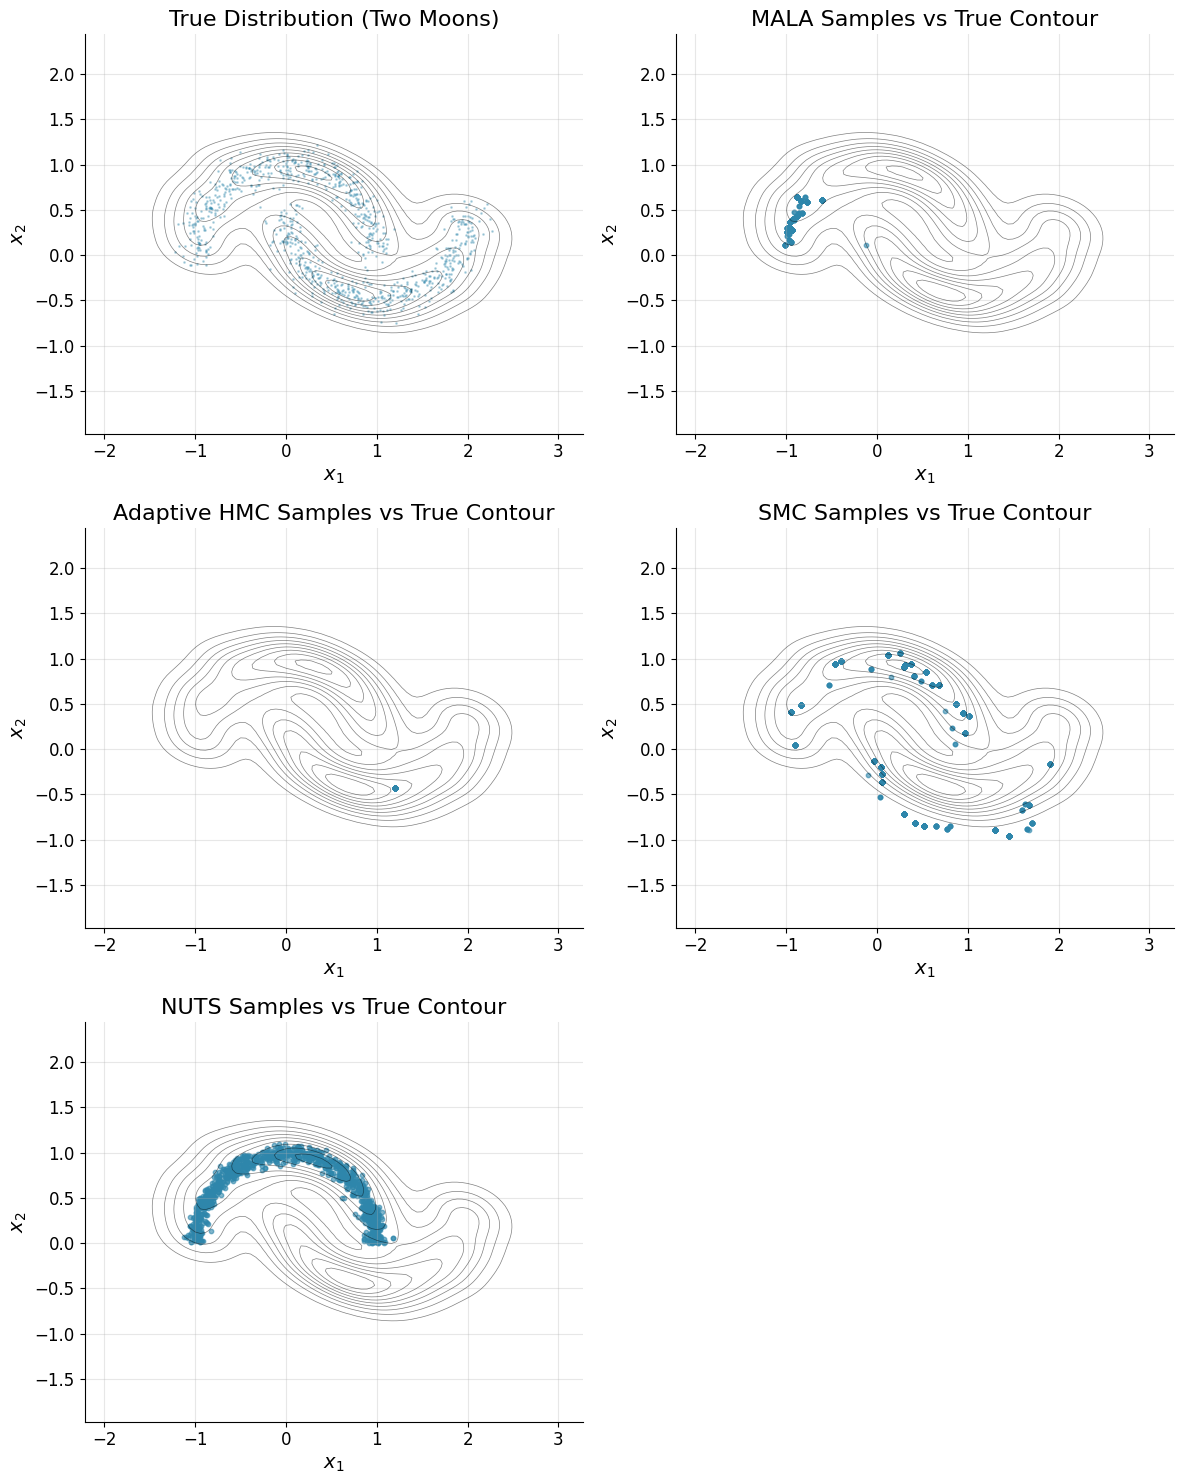

In [5]:
#Sampling from banana distribution
samplers_banana = {
    'MALA': lambda: run_mala(banana_logp, banana_grad_logp, num_samples=1000, step_size=0.02),
    'Adaptive HMC': lambda: run_hmc_adaptive(banana_logp, banana_grad_logp, num_samples=1000, warmup_steps=200),
    'SMC': lambda: run_smc(banana_logp, num_particles=1000),
    'NUTS': lambda: run_nuts(banana_model, num_samples=1000, warmup=200, num_runs=1),
}

print("=== BANANA DISTRIBUTION ===")
banana_sampler_samples, banana_results = run_experiment(samplers_banana)
# Plot comparison
true_banana_samples = generate_true_banana_samples(n=1000, b=1.0, d=2)
plot_true_contour_and_samples(true_banana_samples, banana_sampler_samples, name='Banana')


#Sampling from two moons distribution
samplers_two_moons = {
    'MALA': lambda: run_mala(two_moons_logp_circular, grad_logp_circular, num_samples=1000, step_size=0.02),
    'Adaptive HMC': lambda: run_hmc_adaptive(two_moons_logp_circular, grad_logp_circular, num_samples=1000, warmup_steps=200),
    'SMC': lambda: run_smc(two_moons_logp_circular, num_particles=1000),
    'NUTS': lambda: run_nuts(two_moons_model, num_samples=1000, warmup=200, num_runs=1),
}

print("=== TWO MOONS DISTRIBUTION ===")
two_moons_sampler_samples, two_moons_results = run_experiment(samplers_two_moons)
# Plot comparison
true_two_moons_samples =  get_data(1000, normalize=False)
plot_true_contour_and_samples(true_two_moons_samples, two_moons_sampler_samples, name='Two Moons')


In [6]:
# Compute metrics
banana_validation_results = compute_validation_metrics(true_banana_samples, banana_sampler_samples)
print("Validation Results for Banana Distribution:")
print(pd.DataFrame(banana_validation_results).T)

# Compute metrics
two_moons_validation_results = compute_validation_metrics(true_two_moons_samples, two_moons_sampler_samples)
print("\nValidation Results for Two Moons Distribution:")
print(pd.DataFrame(two_moons_validation_results).T)

Validation Results for Banana Distribution:
                      ESS  W1_to_True
MALA             1.518757    3.881621
Adaptive HMC     1.953619    8.279495
SMC           1054.966568    0.539244
NUTS           453.765086    0.482360

Validation Results for Two Moons Distribution:
                      ESS  W1_to_True
MALA             4.134651    1.704741
Adaptive HMC  1000.000000    1.625476
SMC            951.693007    0.429641
NUTS           134.430128    0.822763


### Interpreting the Results

- **SMC** stands out: high ESS and low W₁, confirming its ability to explore both modes globally.
- **NUTS** performs well on banana and decently on moons — but only covers one mode per run, requiring multiple chains for full coverage.
- **Adaptive HMC**, despite tuning, fails on the banana and gives misleading results on moons — sensitive to geometry and initialization.
- **MALA** occupies a middle ground: it follows gradients, so it finds high-density regions efficiently, but still gets trapped in local modes. Its moderate ESS reflects this - far from complete exploration. This makes MALA representative of many practical EBM setups: locally informed, globally blind.

For details on how we diagnosed this — including autocorrelation analysis and ESS interpretation — see **Appendix A**.

## But What If We Help NUTS? (The Human in the Loop)

So far, we’ve treated all samplers equally: one run, random initialization, no tuning.

But in real research, we don’t leave high-end samplers like NUTS to fend for themselves.

We’ll run NUTS again — but this time, twice with different random seeds.

Sample: 100%|██████████| 1200/1200 [01:24, 14.17it/s, step size=5.61e-02, acc. prob=0.910]
Chain 1 mean: [0.02998984 0.5959706 ]
Sample: 100%|██████████| 1200/1200 [00:35, 33.37it/s, step size=1.44e-01, acc. prob=0.771]
Chain 2 mean: [ 0.9764923  -0.60815865]
Combined mean: [ 0.50324106 -0.00609401]
Chain means spread: [0.47325122 0.6020646 ]


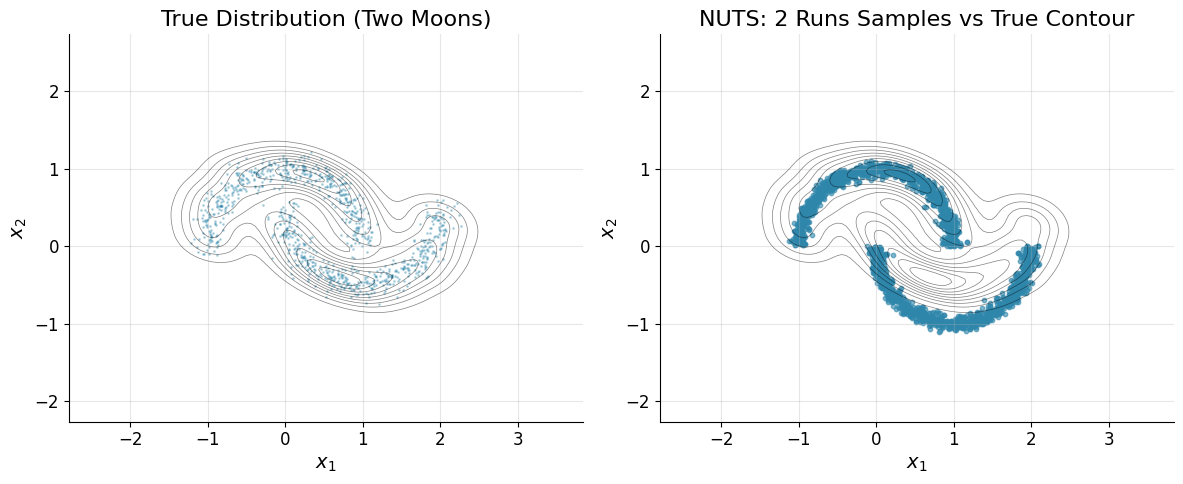

In [7]:
samples_2run = run_nuts(two_moons_model, num_samples=1000, warmup=200, num_runs=2)
plot_true_contour_and_samples(true_two_moons_samples, {'NUTS: 2 Runs':samples_2run}, name='Two Moons')


The first run found the upper moon; the second found the lower. Combined, they cover the full distribution.

But note: this success depends on **chance** — that one chain happened to initialize in each basin.

If both had started near the same mode, we’d have missed half the story.

This highlights a key limitation: **even adaptive samplers like NUTS cannot guarantee exploration of all modes without human oversight or additional mechanisms (like tempering or SMC).**

In [8]:
samples_2run
chain1 = samples_2run[:1000]
chain2 = samples_2run[1000:]

# Compute distance between chain means
d = np.linalg.norm(chain1.mean(axis=0) - chain2.mean(axis=0))
print(f"Distance between chain means: {d:.3f}")

if d < 1.0:
    print("Chains may be stuck in same mode")
else:
    print("Chains likely span both modes")

Distance between chain means: 1.532
Chains likely span both modes


## Discussion: Why This Matters for EBMs

These results explain why training Energy-Based Models is so difficult:

- **HMC failed** due to poor tuning — yet most EBM papers assume perfect sampling
- **NUTS looked perfect** but missed a mode — exactly the risk in EBM negative phase
- Only **SMC** reliably found both modes

But SMC is expensive and rarely used in deep learning.

So when an EBM appears to learn "connected" moons, ask:
> Did it truly model the full distribution — or did its sampler just get stuck?

And unlike here, where we can check against ground truth, in real EBM training:
- There is no true distribution to compare to
- No warning when mixing fails
- The model learns to raise energy where the chain goes — not everywhere

This creates a **silent feedback loop of failure**.

Which brings us to diffusion models — which avoid MCMC entirely by learning the reverse process directly.

## Conclusion: Trust, But Verify

Modern MCMC methods are impressive — but they are not infallible.

Our experiments show:
- Untuned HMC can fail catastrophically
- NUTS can converge confidently to a subset of the support
- Only global methods like SMC consistently capture multi-modality

**The most dangerous failure is the one you don't notice.**

When building generative models, we must:
- Diagnose mixing rigorously
- Visualize per-chain behavior
- Prefer methods with fewer silent failure modes

And sometimes, the best solution is not better sampling — but avoiding sampling altogether.
That’s the promise of diffusion models.

# Appendix A: MCMC Diagnostics — A Practitioner’s Guide

>  **Use this guide when:**
> - You suspect your sampler missed a mode
> - ESS looks too good to be true
> - You're debugging an EBM or diffusion model
> - You need to compare sampling methods fairly

These tools helped us catch silent failures in NUTS and HMC — they’ll help you too.

---

## 1. Diagnostic Workflow: Step-by-Step

Follow this checklist to evaluate any MCMC sampler on multi-modal problems:

1. **Run multiple chains** with different seeds
2. **Check per-chain means** — do they cluster in one region?
3. **Plot samples vs true contour** — visual inspection is king
4. **Compute ESS (min across dims)** and W₁
5. **Plot autocorrelation** — look for patterns
6. **Compare bulk vs tail ESS** — disagreement suggests poor tail coverage
7. **Ask**: "Could this look good even if it missed a mode?"

---

## 2. Interpreting Autocorrelation Plots

Autocorrelation reveals how quickly a chain "forgets" its past. But patterns matter:

### Rapid Drop to Zero (HMC, MALA)
- **What it means**: The chain decorrelates fast.
- **But beware**: This can happen if it's stuck in one mode (e.g., one moon).
- **Risk**: High ESS may mask global failure.

### Oscillating Around Zero (SMC)
- **What it means**: Anti-persistent behavior — values alternate.
- **Why**: Resampling causes abrupt jumps.
- **Good sign**: Indicates global exploration.

### Slow Decay (NUTS, well-tuned HMC)
- **What it means**: Long memory; slow mixing.
- **Watch out**: Low ESS → inefficient sampling.

### Flat or Missing Plot
- **What it means**: One dimension barely changes.
- **Action**: Check `std(x[:,i])`; consider reinitialization.

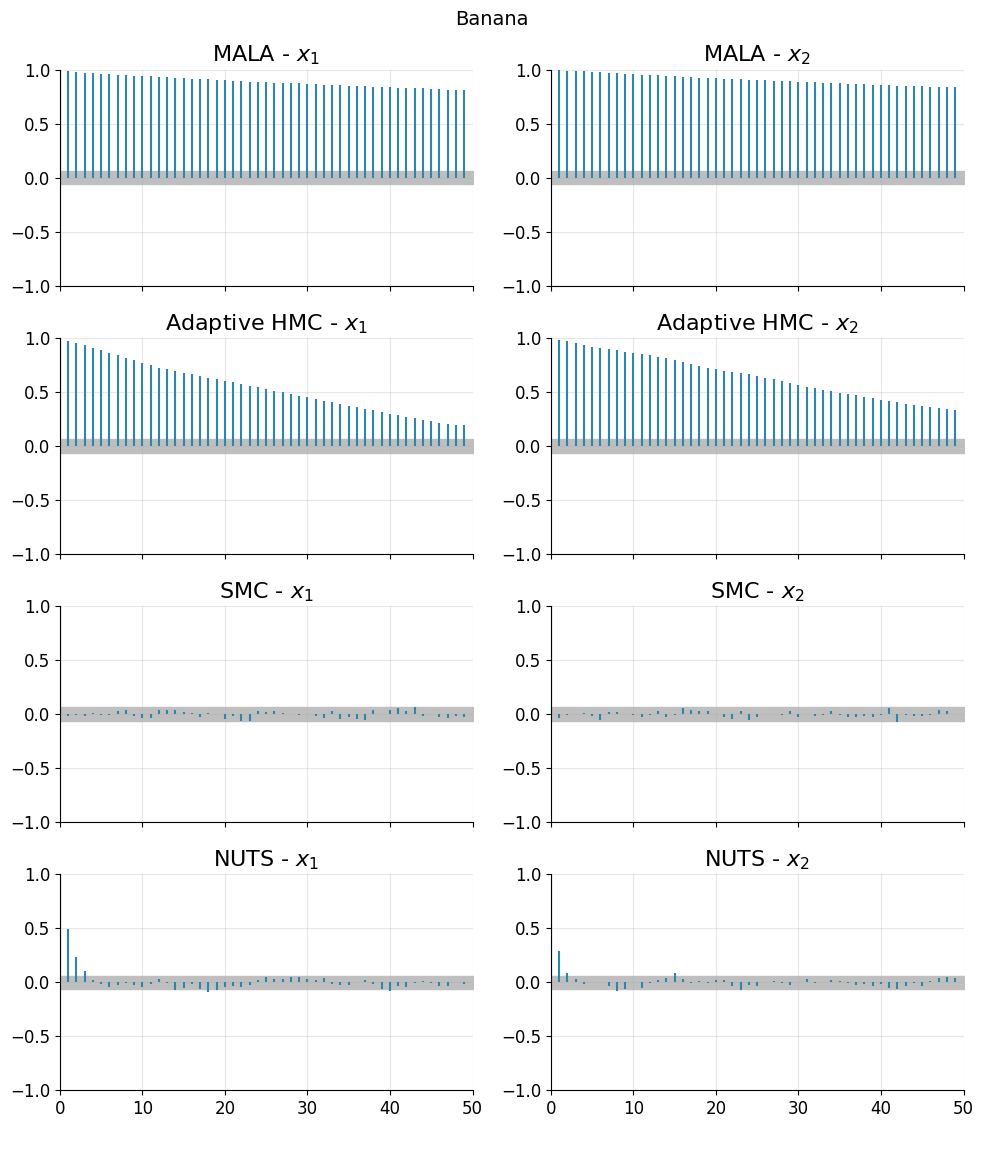

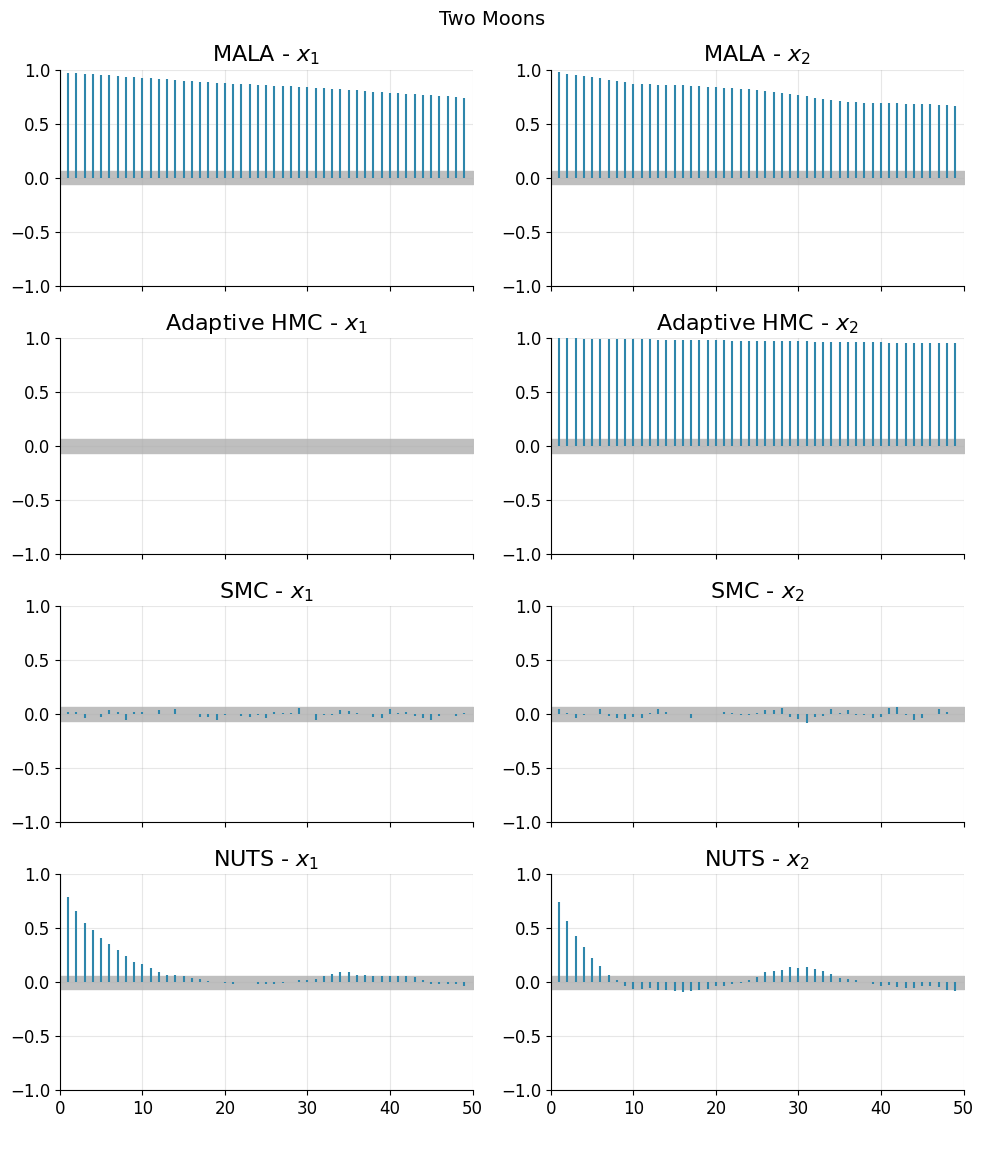

In [9]:
# Run plots
plot_diagnostics_grid_az(banana_sampler_samples, title="Banana")
plot_diagnostics_grid_az(two_moons_sampler_samples, title="Two Moons")

> "SMC shows oscillatory autocorrelation — a signature of particle resampling.  
> Adaptive HMC drops to zero immediately, suggesting confinement despite high ESS."

---

## 3. Key Lessons from This Study

| Insight | Practical Tip |
|--------|---------------|
| **High ESS doesn’t guarantee good sampling** | Always pair with visualization and W₁ |
| **Oscillating autocorrelation = global exploration** | Look for this in SMC, tempering, or population methods |
| **ESS > N is an estimation artifact** | Clip ESS at number of samples for reporting |
| **Silent failure is the norm, not the exception** | Assume your sampler missed something until proven otherwise |
| **No single metric tells the whole story** | Use a **triangulation approach**: ESS + W₁ + plots |

---

## 4. Chain Behavior Inspection (Coming Soon)

We’re extending this guide to include:
- How to detect metastability
- When to use R-hat, split-Rhat, and energy diagnostics
- Detecting divergences in HMC/NUTS

Stay tuned.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de7d40e8-6998-4e65-8626-6720908f4576' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>